<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Spring2025/blob/main/Module_5/27_Bayesian_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial notebook for the Spring 2025 MSE 510, University of Tennessee Knoxville, Department of Materials Science and Engineering.

**Least square fit and Bayesian Inference**, April 1, 2024

- Made by Sergei V. Kalinin (2023), https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ
- Based on the research notebooks by Maxim Ziatdinov (2022), https://scholar.google.com/citations?user=YnSdOoUAAAAJ
- Some of the relevant code has been written by ChatGPT

# The usual way: Least square fit

Least square (LS) fitting is one of the most basic tools used across all scientific domains. Given the certain number of measured data points (x,y) and a function f(theta), we aim to find the parameter vector theta' that makes predicted values of the function y_hat = f(theta',x) as close to the actual measured values, y. The way the "as close as possible' is defined is via means square deviation between the predicted and actual values, L. From optimization point of view, we seek to find the minimim of the function L in the parameter space, theta.


Typically, LS methods are learned on many levels - in high school and college for linear functions, in college for non-linear and more complex scenarios. Tremendous amount of theories have been developed to establish whether the fit is "right" based on the structure of errors and residues, number of free parameters in the data vs. function, and so on.

If interested, there is a number of very useful blog posts and Wiki articles, for example:

- The least square fit article on Wikipedia contains quite in-depth technical details: https://en.wikipedia.org/wiki/Least_squares
- Another good description is on Wolfram MathWorld: https://mathworld.wolfram.com/LeastSquaresFitting.html
- Tremendous source of learning are Medium blogs on "Towards Data Science" - it is always possible to find a take on problem that matches your interests, style, and level. For example, https://towardsdatascience.com/ordinary-least-squares-regression-da96dde239d5

However, let's look at the LS fitting from physics perspective. Ultimately, our equation represents the physical knowledge that we have. Fitting the equation to data seeks the dual role of establishing model parameters, and potentially figuring out whether the model is correct (based on quality of the fit and numerical values of parameters). We expect to get the point estimates of the model parameters, and some information of how well the model worked. This information is the strucutre of the residues (y - y_hat), and error bars on parameters (which we get from the curvature of the Jacobian matrix).

So, let's first play with the LS using SciPy, the basic scientific Python library:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

Let's define a simple but "inconvenient" function, namely a function formed by two line segments and the jump between them. As before, our measurements are the values of the function plus some noise

In [2]:
# This is our ground truth - how the nature really behaves
def func(x, a = 0.2, b = 1, c = 0.5, d = 2, jump_point = 2.2):
    result = np.zeros_like(x)
    mask1 = x < jump_point
    mask2 = x >= jump_point
    result[mask1] = a * x[mask1] + b
    result[mask2] = c * x[mask2] + d
    return result

# This is our data generation process - what can we measure
def measure_func(x, noise= 0.1):
    return func(x) + noise * np.random.randn(len(x))

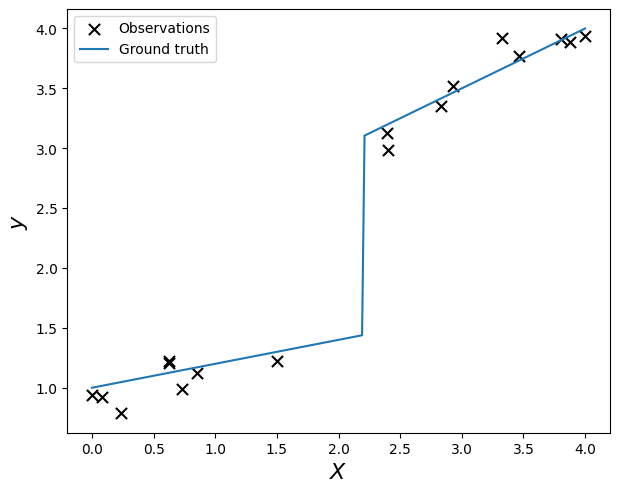

In [3]:
# We define random seed to make sure that analysis is reproducible
# Caveat - note that for testing we try multiple seeds to make sure algorithm works on average and its not particularly lucky parameter value

np.random.seed(42)

# Define the interval
X_bounds = np.array([0, 4])

# Select several (size) measurement points and for convenience add the ends of the interval
X = np.random.uniform(X_bounds[0], X_bounds[1], size=(15,))
X = np.append(X, X_bounds)
X = np.sort(X)

# Perform measurements at these locations
y = measure_func(X)

# Define the interval on which we want to sample our discovered function
X_unmeasured = np.linspace(X_bounds[0], X_bounds[1], 200)

# Define the ground truth - what would the value of true data generation function be
ground_truth = measure_func(X_unmeasured, noise=0)

# And plot the ground truth and observations
_, ax = plt.subplots(dpi=100, figsize=(7, 5.5))
ax.set_xlabel("$X$", fontsize=16)
ax.set_ylabel("$y$", fontsize=16)
ax.scatter(X, y, marker='x', c='k', s=64, zorder=1, label="Observations", alpha=1.0)
ax.plot(X_unmeasured, ground_truth, label='Ground truth')
ax.legend(loc='best');

Now let's try to find our function. Here, we have access to the measurements, we know the function form (very important assumption - we will return to it later!) but we do not know what the  parameters of the fucntion are. How can we discover them from measurements?

Fit parameter values are:  [-0.7086702   0.95837742  0.94644845  0.47326979  0.5       ]


<ipython-input-4-4182df035bf0>:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(jump_function, X, y, p0 = [0.2, 1, 0.5, 2, 0.5]);


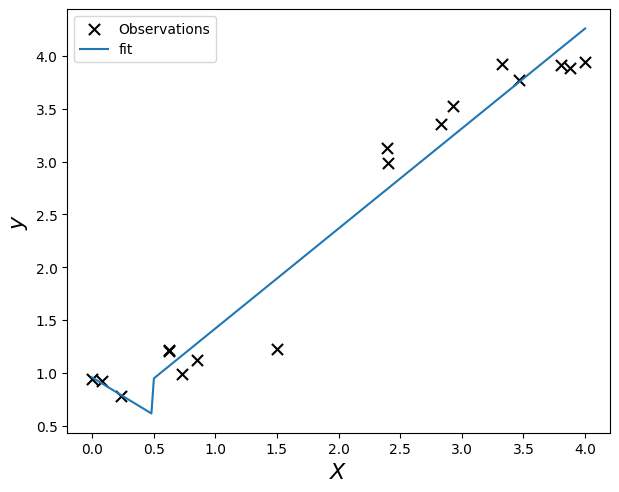

In [4]:
# Define the jump function with two linear segments
# Note that this function has the same form as our data generation process
# For fun, you can define a different function and see how the process works

def jump_function(x, a, b, c, d, jump_point):
    result = np.zeros_like(x)
    mask1 = x < jump_point
    mask2 = x >= jump_point
    result[mask1] = a * x[mask1] + b
    result[mask2] = c * x[mask2] + d
    return result

# Use curve_fit to fit the data to the jump function
# Note the very important argument p0 - these are our initial guesses of parameter values
popt, pcov = curve_fit(jump_function, X, y, p0 = [0.2, 1, 0.5, 2, 0.5]);

# Print the optimized parameters
print("Fit parameter values are: ", popt)

# Generate the data to plot the jump function
y_hat = jump_function(X_unmeasured, *popt)

# Plot the results
_, ax = plt.subplots(dpi=100, figsize=(7, 5.5))
ax.set_xlabel("$X$", fontsize=16)
ax.set_ylabel("$y$", fontsize=16)
ax.scatter(X, y, marker='x', c='k', s=64, zorder=1, label="Observations", alpha=1.0)
ax.plot(X_unmeasured, y_hat, label='fit')
ax.legend()

Looks like the fit works. Well, let's experiment a little bit:
1. First and foremost, note that when we do the fit, we have the vector of initial guesses p0 = [0.2, 1, 0.5, 2, 2]. Experiment what happens if the parameter values are off - start with setting the last value of the list (position of the innflection point) to 1 and 3. What happens with the fit?
2. Change the number of measurement points. Try 20 and 200. How did it affect the fit parameters?

So, the general observations are:

1. LS fit is a very powerful method of finding the values of the function parameters tha allow best fit to the data
2. The fit can easily converge to the wrong metastable minimum, even for very simple functions. This depends on how good our initial guesses are.
3. Before the fit, the parameters in the LS "can be anything" (more rigorously, we start descent from our initial guesses). During the fit, it is possible to introduce some form of constraints (e.g. see libraries such as LMFit, https://lmfit.github.io/lmfit-py/), but usually in a very limited way (e.g. some parameter can have upper or lower bound, or be set to be fixed).
4. Correspondingly, it is very difficult to add prior knowledge to the LS Fit. We generally apply it to data and then analyze the results of the fit, but do not intervene in the fitting process.
5. If we have multiple models of system behavior (multiple fit functions), selecting the "right one" is a challenge. Typically we weight the behavior of the fit per se (errors and residues), complexity of the function, and prior physical knowledge, often in the ad hoc way.


# Bayesian fit using GPax

Bayesian Inference (BI) allows to address these issues in a principled way. Let's start with the basics and install [GPax](https://github.com/ziatdinovmax/gpax) package:

In [5]:
!pip install gpax #git+https://github.com/ziatdinovmax/gpax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.9/373.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 kB 12.9 MB/s eta 0:00:00


In [6]:
#!pip install numpyro==0.10.0

Imports:

In [7]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy as dc
from typing import Dict

import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import arviz as az

import warnings

gpax.utils.enable_x64()
warnings.filterwarnings("ignore", category=UserWarning)

Now let's generate some synthetic data.

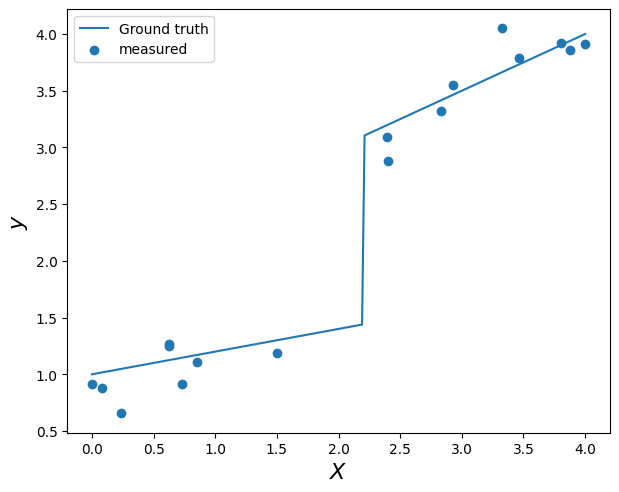

In [8]:
np.random.seed(42)

# Define the interval
X_bounds = np.array([0, 4])

# Select several (size) measurement points and for convenience add the ends of the interval
X_measured = np.random.uniform(X_bounds[0], X_bounds[1], size=(15,))
X_measured = np.append(X_measured, X_bounds)
X_measured = np.sort(X_measured)

# Perform measurements at these locations
y_measured = measure_func(X_measured, noise = 0.15)

# Define the interval on which we want to sample our discovered function
X_unmeasured = np.linspace(X_bounds[0], X_bounds[1], 200)
ground_truth = measure_func(X_unmeasured, noise=0)

_, ax = plt.subplots(dpi=100, figsize=(7, 5.5))
ax.set_xlabel("$X$", fontsize=16)
ax.set_ylabel("$y$", fontsize=16)
ax.plot(X_unmeasured, ground_truth, label='Ground truth')
ax.scatter(X_measured, y_measured, label='measured')
ax.legend()

Now let's introduce two probabilistic models, sigmoidal and piecewise. Now, we are defining the function and the priors. The function is the same as before. However, now we also specify what do we know about the parameters - meaning what distribution they are drawn from. If the distribution is very broad, it means that we do not know much (so called non-informative prior). If the distribution is very narrow, that means that we have high level of belief that this particular parameter has certain value.

Note that the prior distribution can be multimodal - we can easily say that we beleive that jump point can be either at 2 +/- 0.1, or 3 +/-0.1 with probabilities 0.3 and 0.7 respectively.

This capability to specify prior knowledge is the greatest strength and greates weakness of Bayesian methods. It is strength because we can add it in a principled way. It is a weakkness because we need to get it from somewhere (aka domain experience).

In [9]:
def sigmoidal(x, params):
    beta1 = params["beta1"]
    beta2 = params["beta2"]
    beta3 = params["beta3"]
    beta4 = params["beta4"]
    return beta1 + beta2 / (1 + jnp.exp(-beta3 * (x-beta4)))

def sigmoidal_prior():
    return {
        "beta1": numpyro.sample("beta1", numpyro.distributions.Normal(0, 1)),
        "beta2": numpyro.sample("beta2", numpyro.distributions.Normal(0, 1)),
        "beta3": numpyro.sample("beta3", numpyro.distributions.Normal(0, 1)),
        "beta4": numpyro.sample("beta4", numpyro.distributions.Normal(0, 1))
        }

In [10]:
def piecewise(x, params):
    t = params["t"]
    beta1 = params["beta1"]
    beta2 = params["beta2"]
    beta3 = params["beta3"]
    beta4 = params["beta4"]

    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: x*params["beta1"] + params["beta2"], lambda x: x*params["beta3"]+params["beta4"]])

def piecewise_priors():
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(2, 4))
    beta1 = numpyro.sample("beta1", numpyro.distributions.Normal(0, 1))
    beta2 = numpyro.sample("beta2", numpyro.distributions.Normal(0, 1))
    beta3 = numpyro.sample("beta3", numpyro.distributions.Normal(0, 1))
    beta4 = numpyro.sample("beta4", numpyro.distributions.Normal(0, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "beta1": beta1, "beta2": beta2, "beta3": beta3, "beta4": beta4}

As a reminder, always a good idea to check how the distributions really look like:

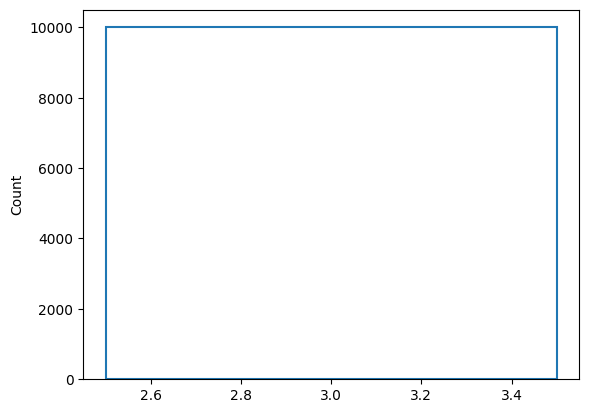

In [11]:
d = numpyro.distributions.Uniform(3, 1) #Gamma(1, 1)
gpax.utils.dviz(d, samples=10000)

Now let's run Bayesian inference, meaning given the experimental data, function, and priors on function parameters, we aim to update our beliefs in what the parameters are. In Bayesian language, that means transition from priors to posteriors. Posteriors quantify what we know after the experiment.

We are not going to explore the details of the process in depth, but have a look at the parameters num_warmup, num_samples, and num_chains. Depending on conditions, these can result in "unphysical" artefacts in answers.

Generally, Bayesian fit will give us estimates fo rthe parameters, namely mean, standard deviation, median, and other statistical descriptors. However, it is important to note that thes enumbers are sampled from the full posterior distribution. These numbers are sufficient to describe it if it is close to Gaussian (then they have meaning close to errors in classical LS fit).

However, the posterior distribution can be much more complex then Gaussian, and then mean and dispersion is insufficient to describe it. It can even be multimodal!

In [12]:
model = piecewise
model_prior = piecewise_priors

#model = sigmoidal
#model_prior = sigmoidal_prior

key1, key2 = gpax.utils.get_keys()

spm = gpax.models.sPM(model, model_prior) #sPM(model, model_prior)
spm.fit(key1, X_measured, y_measured, num_warmup=500, num_samples=1000, num_chains=5)

sample: 100%|██████████| 1500/1500 [00:11<00:00, 125.08it/s, 255 steps of size 4.51e-03. acc. prob=0.74] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      0.28      0.18      0.28     -0.00      0.58    217.50      1.03
     beta2      0.85      0.13      0.85      0.64      1.07    174.40      1.04
     beta3      0.67      0.12      0.67      0.48      0.87    286.12      1.02
     beta4      1.42      0.38      1.44      0.82      2.07    286.14      1.02
     noise      0.22      0.05      0.21      0.14      0.29    306.86      1.01
         t      2.21      0.12      2.21      2.05      2.39    648.41      1.01

Number of divergences: 0


In [13]:
#gpax.models.*?

Now we can visualize ground truth, measurements, sampled predictions, and predictiive mean. Note how predictive mean behaves at the interval between measurement points that contains jump.

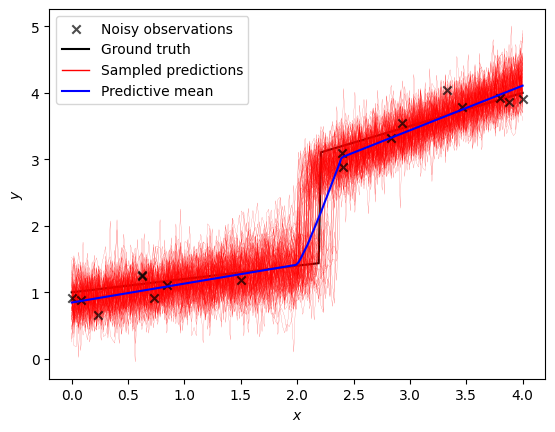

In [14]:
mean, samples = spm.predict(key2, X_unmeasured, take_point_predictions_mean=False)

_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X_measured, y_measured, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
ax.plot(X_unmeasured, ground_truth, c='black', zorder=0, label="Ground truth")

# Note that we show only 10 of them for clarity
for y1 in samples[:100]:
    ax.plot(X_unmeasured, y1, lw=.1, zorder=0, c='r', alpha=1)
l, = ax.plot(X_unmeasured, samples[0], lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_unmeasured, mean.mean(axis = 0), lw=1.5, zorder=1, c='b', label='Predictive mean')
ax.legend(loc='best')
l.set_alpha(0)

In [15]:
samples.shape

(5000, 200)

In [16]:
mean.shape, samples.shape, X_unmeasured.shape

((5000, 200), (5000, 200), (200,))

We can also look at what the possible functions may be (without noise). These are possible functions consistent with data and chosen priors.

(5000, 200)


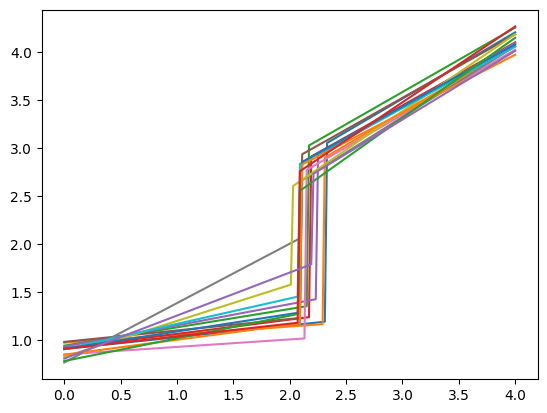

In [17]:
_, ax = plt.subplots(dpi=100)
print(mean.shape)
plt.plot(X_unmeasured, mean[5:20,:].T);

Now let's see how much can we trust these predictions:

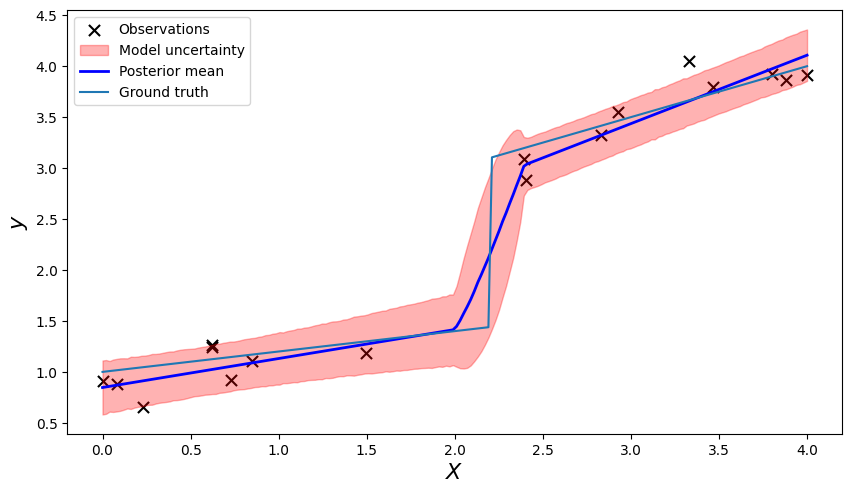

In [18]:
# Plot observed points, mean prediction, and confidence bound

'''
lower_b = mean.mean(axis = 0) - 3*mean.std(axis=0)
upper_b = mean.mean(axis = 0) + 3*mean.std(axis=0)
'''

lower_b = mean.mean(axis = 0) - samples.std(axis=0)
upper_b = mean.mean(axis = 0) + samples.std(axis=0)

fig, ax1 = plt.subplots(1, 1, dpi=100, figsize=(10, 5.5))
ax1.scatter(X_measured, y_measured, marker='x', c='k', label="Observations", s=64)
ax1.fill_between(X_unmeasured, lower_b, upper_b, color='r', alpha=0.3, label="Model uncertainty")

for ax in fig.axes:
  ax.plot(X_unmeasured, mean.mean(axis = 0), lw=2, c='b', label='Posterior mean')
  ax.plot(X_unmeasured, ground_truth, label='Ground truth')
    #ax.set_ylim(3.0, 8)
  ax.set_xlabel("$X$", fontsize=16)
  ax.set_ylabel("$y$", fontsize=16)
  ax.legend(loc='best', fontsize=10)
plt.show()

Now, as mentioned above, the real strength of BI is that we can get the posterior distirbutions of parameters. The way we do that is by getting samples from Monte-Carlo chain. Practically, use code below (for those curious, the commented line shows you the strucutre of the dictionary containing this information)

In [19]:
params = spm.get_samples()
#params.items()

For visualization of everything related to Bayesian methods, the great library is Arviz, https://www.arviz.org/en/latest/. It is universal, so we will just use it.  

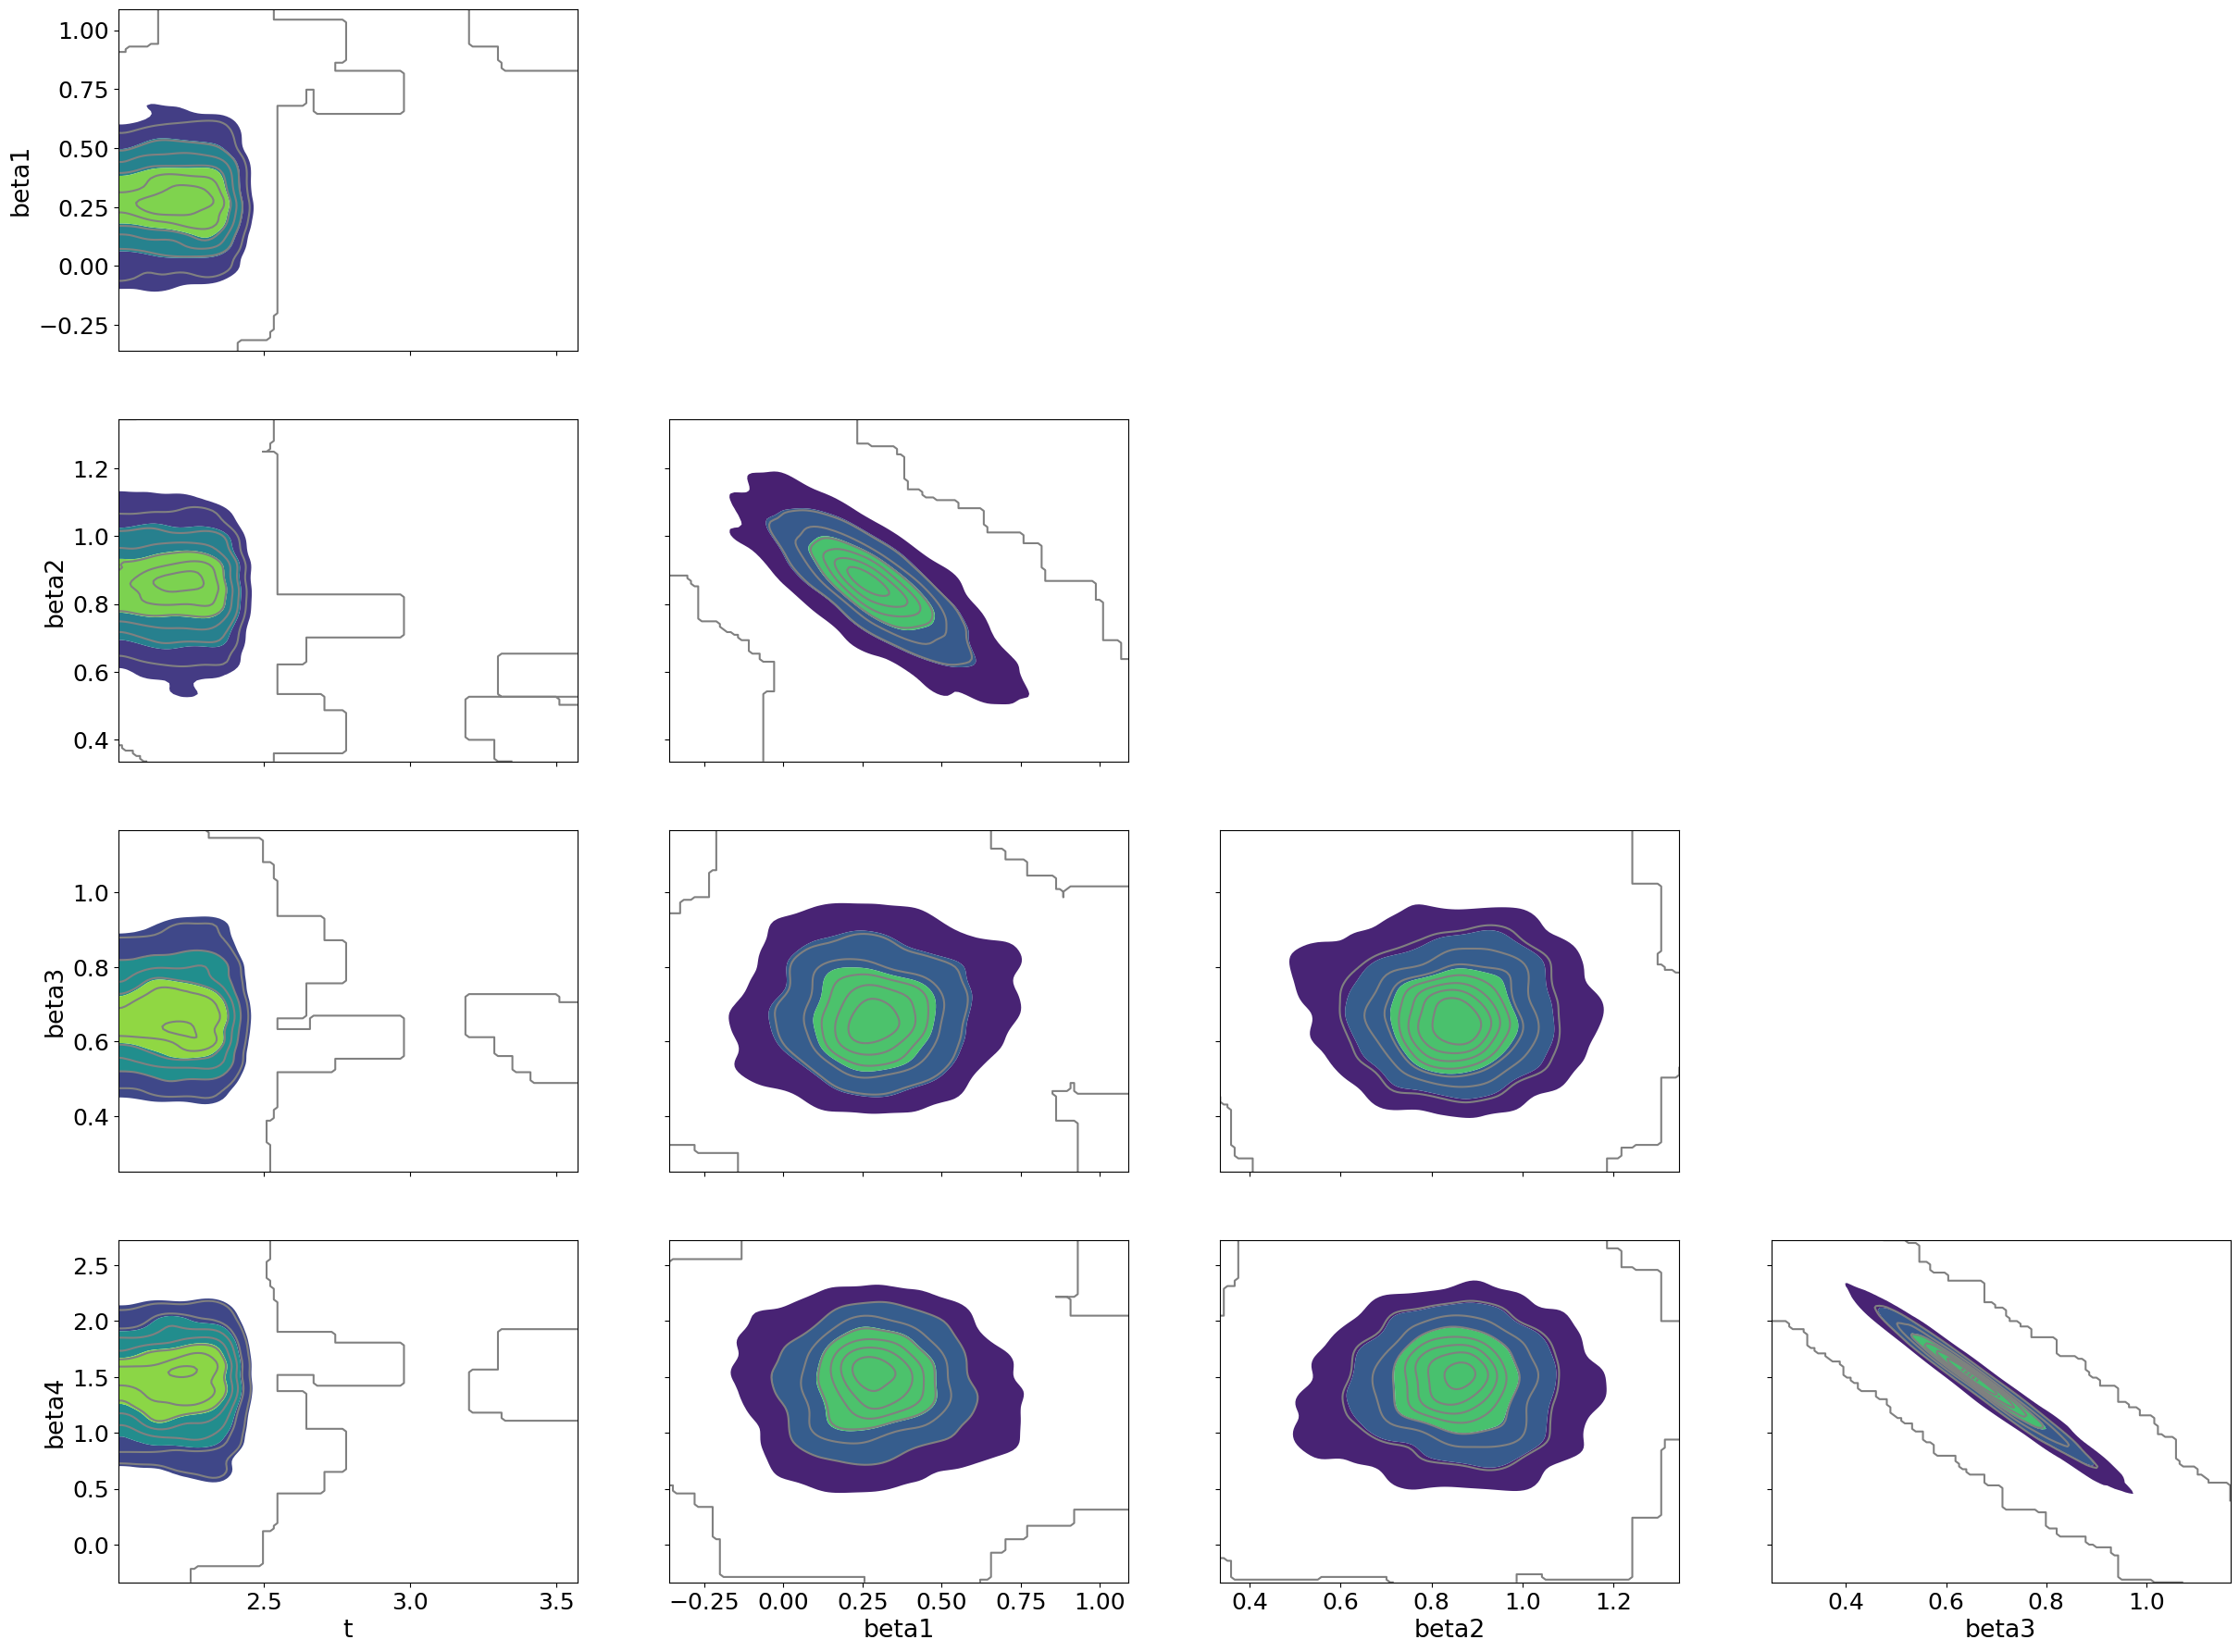

In [20]:
# Plot 2D joint posterior distributions
# Make sure to select right variable names!

az.plot_pair(params, kind='kde', var_names=['t','beta1', 'beta2', 'beta3', 'beta4'],
            divergences=False,
            textsize=18)

# show plot
plt.show()

We can also just explore the 1D distributions (so called marginalized densities. This means that BI finds joint distirbution of all model parameters in high dimensional spaces. For 2D represnetations above and 1D representations below, we average (marginalze) over the variables we are not interested in.

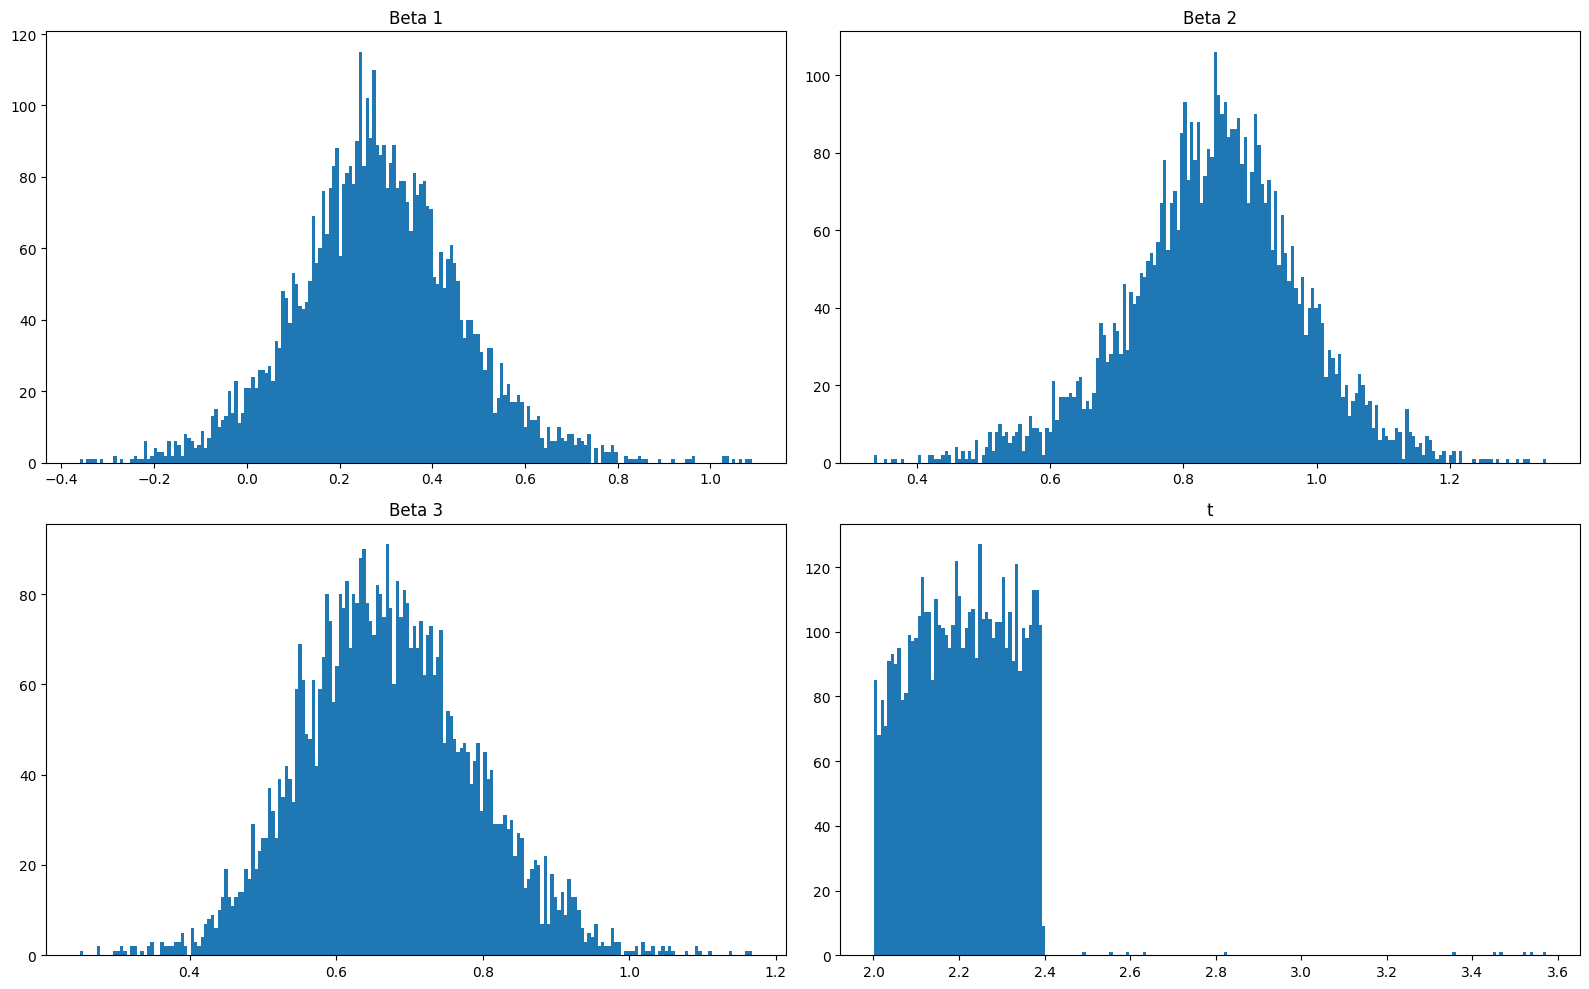

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (16, 10))

# plot distributions of each variable
axs[0, 0].hist(params['beta1'], bins=200)
axs[0, 0].set_title('Beta 1')
axs[0, 1].hist(params['beta2'], bins=200)
axs[0, 1].set_title('Beta 2')
axs[1, 0].hist(params['beta3'], bins=200)
axs[1, 0].set_title('Beta 3')
axs[1, 1].hist(params['t'], bins=200)
axs[1, 1].set_title('t')

# adjust layout and show plot
plt.tight_layout()
plt.show()

Suggested experiments:

1. Experiment with the number of measurement points. How does it affect the posterior probability for the switch point?
2. Experiment with the priors for the sigmoidal and piecewise function. Remember that prior is our belief. We can set it to be limiting (uniform distribution) or allow for flexibility (Gaussian). We can postulate that our variable can be only positive (half-Normal). Practically, priors can be formulated base don physical knowledge or published data.
3. Try the cases where priors include the ground truth (for example, for parameter t in stepwise function and using uniform prior), and cases where this is not the case
4. If curios, experiment with very low noise level and small number of data points (e.g. 10) and play with number of chains (say 2,5, 10).

# Bayesian fit with multiple models: how do we compare

Well, in physics we often do not know what model should we use - rather, we have several candidates. How should we proceed, and can BI help us select the right one?

Yes! First, we define possible models that describe a behavior of interest. Note that in each case we first write them as deterministic functions and then define probabilistic priors over their parameters as separate functions. Here, most of priors are standard normal.

In [22]:
def linear1(x, params):
    return 1 - params["beta1"] * x

def linear1_prior():
    return {
    "beta1": numpyro.sample("beta1", numpyro.distributions.Normal(0, 1))
    }


def linear2(x, params):
    return params["beta0"] - params["beta1"] * x

def linear2_prior():
    return {
    "beta0": numpyro.sample("beta0", numpyro.distributions.Normal(0, 1)),
    "beta1": numpyro.sample("beta1", numpyro.distributions.Normal(0, 1))
    }

def power_law2(x, params):
  return params["beta0"] - params["beta1"] * jnp.power(x, params["beta2"])

def power_law2_prior():
    return {
        "beta0": numpyro.sample("beta0", numpyro.distributions.Normal(0, 1)),
        "beta1": numpyro.sample("beta1", numpyro.distributions.Normal(0, 1)),
        "beta2": numpyro.sample("beta2", numpyro.distributions.Normal(0, 1))
    }


def exponential1(x, params):
    return params["beta0"] * jnp.exp(params["beta1"] * jnp.power(x, params["beta2"]))

def exponential1_prior():
    return {
        "beta0": numpyro.sample("beta0", numpyro.distributions.Normal(0, 1)),
        "beta1": numpyro.sample("beta1", numpyro.distributions.Normal(0, 1)),
        "beta2": numpyro.sample("beta2", numpyro.distributions.Normal(0, 1))
    }


def sigmoidal(x, params):
    beta1 = params["beta1"]
    beta2 = params["beta2"]
    beta3 = params["beta3"]
    beta4 = params["beta4"]
    return beta1 + beta2 / (1 + jnp.exp(-beta3 * (x-beta4)))

def sigmoidal_prior():
    return {
        "beta1": numpyro.sample("beta1", numpyro.distributions.Normal(0, 1)),
        "beta2": numpyro.sample("beta2", numpyro.distributions.Normal(0, 1)),
        "beta3": numpyro.sample("beta3", numpyro.distributions.Normal(0, 1)),
        "beta4": numpyro.sample("beta4", numpyro.distributions.Normal(0, 1))
        }

def piecewise(x, params):
    t = params["t"]
    beta1 = params["beta1"]
    beta2 = params["beta2"]
    beta3 = params["beta3"]
    beta4 = params["beta4"]

    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: x*params["beta1"] + params["beta2"], lambda x: x*params["beta3"]+params["beta4"]])

def piecewise_prior():
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(0, 4))
    beta1 = numpyro.sample("beta1", numpyro.distributions.Normal(0, 1))
    beta2 = numpyro.sample("beta2", numpyro.distributions.Normal(0, 1))
    beta3 = numpyro.sample("beta3", numpyro.distributions.Normal(0, 1))
    beta4 = numpyro.sample("beta4", numpyro.distributions.Normal(0, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "beta1": beta1, "beta2": beta2, "beta3": beta3, "beta4": beta4}

Then we perform the fit using all these models

In [23]:
model_list = [linear1, linear2, power_law2,
              exponential1, sigmoidal, piecewise]

model_prior_list = [linear1_prior, linear2_prior, power_law2_prior,
                    exponential1_prior, sigmoidal_prior, piecewise_prior]

key1, key2 = gpax.utils.get_keys()

mcmc_all = {}
for model, model_prior in zip(model_list, model_prior_list):
    spm = gpax.models.sPM(model, model_prior)
    spm.fit(key1, X_measured, y_measured)
    mcmc_all[str(model)[10:-19]] = dc(spm.mcmc)

sample: 100%|██████████| 4000/4000 [00:05<00:00, 756.01it/s, 3 steps of size 8.51e-01. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1     -0.77      0.04     -0.77     -0.83     -0.70   1506.78      1.00
     noise      0.43      0.08      0.41      0.30      0.55   1138.49      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:04<00:00, 849.53it/s, 3 steps of size 3.28e-01. acc. prob=0.94]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0      0.59      0.15      0.59      0.35      0.82    754.41      1.01
     beta1     -0.91      0.06     -0.91     -1.00     -0.80    836.30      1.01
     noise      0.35      0.07      0.34      0.23      0.44    912.20      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:06<00:00, 584.15it/s, 15 steps of size 1.03e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0      0.63      0.20      0.63      0.30      0.97    506.58      1.00
     beta1     -0.84      0.23     -0.83     -1.19     -0.46    331.60      1.00
     beta2      1.08      0.19      1.06      0.77      1.37    356.13      1.00
     noise      0.36      0.07      0.35      0.25      0.46    686.60      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:06<00:00, 574.69it/s, 31 steps of size 5.07e-02. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0      0.62      0.19      0.61      0.31      0.92    275.88      1.00
     beta1      0.94      0.31      0.90      0.48      1.45    238.60      1.00
     beta2      0.57      0.14      0.55      0.35      0.79    256.22      1.00
     noise      0.40      0.08      0.38      0.28      0.52    549.63      1.00

Number of divergences: 1


sample: 100%|██████████| 4000/4000 [00:05<00:00, 707.54it/s, 15 steps of size 2.20e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      0.88      0.12      0.89      0.69      1.06    612.32      1.00
     beta2      3.09      0.20      3.07      2.77      3.40    520.18      1.00
     beta3      2.30      0.43      2.29      1.59      2.98    555.11      1.00
     beta4      2.10      0.11      2.11      1.91      2.26    973.49      1.00
     noise      0.21      0.04      0.20      0.14      0.28    682.70      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:38<00:00, 103.55it/s, 1023 steps of size 2.27e-03. acc. prob=0.85]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      0.29      0.16      0.29      0.04      0.55    456.42      1.00
     beta2      0.85      0.12      0.85      0.65      1.05    460.04      1.00
     beta3      0.66      0.11      0.65      0.48      0.84    308.87      1.00
     beta4      1.47      0.37      1.47      0.86      2.05    312.28      1.00
     noise      0.21      0.05      0.20      0.14      0.28    444.29      1.00
         t      1.95      0.25      1.97      1.57      2.36    432.25      1.01

Number of divergences: 0


And now we can compare them using widely applicable information criterion (WAIC):

In [24]:
az.compare(mcmc_all, ic="waic")

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
piecewise,0,1.325062,3.290353,0.000000,4.556346e-01,2.314426,0.000000,True,log
sigmoidal,1,1.298050,3.832389,0.027012,5.443654e-01,2.638866,2.506932,True,log
linear2,2,-6.851916,2.368320,8.176979,0.000000e+00,2.919979,3.373738,True,log
power_law2,3,-7.688548,2.950265,9.013611,0.000000e+00,2.626541,3.154568,True,log
exponential1,4,-9.048449,2.518579,10.373511,0.000000e+00,2.060892,2.697333,True,log
linear1,5,-9.932955,1.621358,11.258017,1.354472e-13,3.272561,3.657535,True,log


In [25]:
mcmc_all

{'linear1': <numpyro.infer.mcmc.MCMC at 0x7a564499eb50>,
 'linear2': <numpyro.infer.mcmc.MCMC at 0x7a5643d73190>,
 'power_law2': <numpyro.infer.mcmc.MCMC at 0x7a56570a10d0>,
 'exponential1': <numpyro.infer.mcmc.MCMC at 0x7a56570ce610>,
 'sigmoidal': <numpyro.infer.mcmc.MCMC at 0x7a564492eb50>,
 'piecewise': <numpyro.infer.mcmc.MCMC at 0x7a564412e610>}

Make a prediction with the best model:

In [26]:
spm = gpax.models.sPM(piecewise, piecewise_prior)
spm.fit(key1, X_measured, y_measured)
mean, samples = spm.predict(key2, X_unmeasured)

sample: 100%|██████████| 4000/4000 [00:38<00:00, 103.50it/s, 1023 steps of size 2.27e-03. acc. prob=0.85]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      0.29      0.16      0.29      0.04      0.55    456.42      1.00
     beta2      0.85      0.12      0.85      0.65      1.05    460.04      1.00
     beta3      0.66      0.11      0.65      0.48      0.84    308.87      1.00
     beta4      1.47      0.37      1.47      0.86      2.05    312.28      1.00
     noise      0.21      0.05      0.20      0.14      0.28    444.29      1.00
         t      1.95      0.25      1.97      1.57      2.36    432.25      1.01

Number of divergences: 0


And plot the results

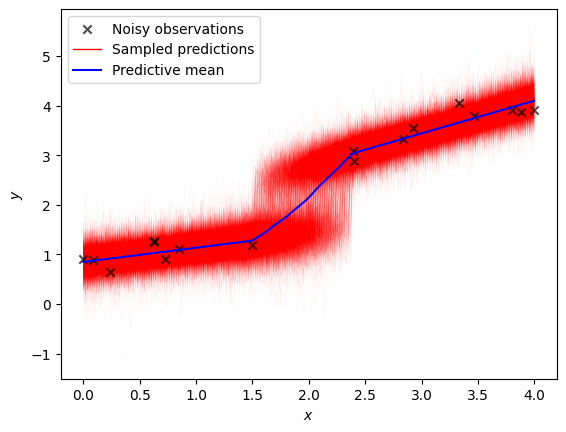

In [27]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X_measured, y_measured, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
#ax.plot(X, y, c='black', zorder=0, label="Ground truth")
for y1 in samples:
    ax.plot(X_unmeasured, y1, lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_unmeasured, samples[0], lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_unmeasured, mean, lw=1.5, zorder=1, c='b', label='Predictive mean')
ax.legend(loc='best')
l.set_alpha(0)

Make a prediction with the second best model:

In [28]:
spm = gpax.models.sPM(sigmoidal, sigmoidal_prior)
spm.fit(key1, X_measured, y_measured)
mean, samples = spm.predict(key2, X_unmeasured)

sample: 100%|██████████| 4000/4000 [00:06<00:00, 638.80it/s, 15 steps of size 2.20e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      0.88      0.12      0.89      0.69      1.06    612.32      1.00
     beta2      3.09      0.20      3.07      2.77      3.40    520.18      1.00
     beta3      2.30      0.43      2.29      1.59      2.98    555.11      1.00
     beta4      2.10      0.11      2.11      1.91      2.26    973.49      1.00
     noise      0.21      0.04      0.20      0.14      0.28    682.70      1.00

Number of divergences: 0


Plot results. Note that the dispersion in sampled predictions is effectively a predictive uncertainty

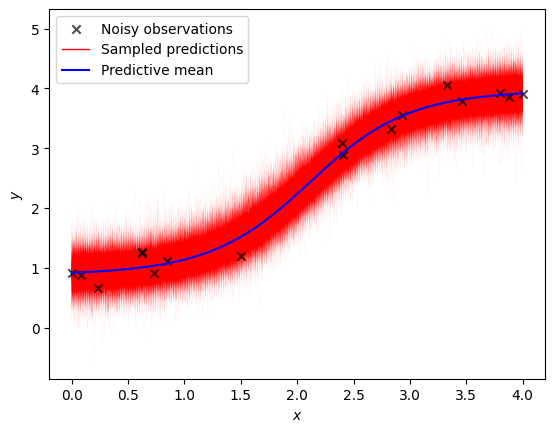

In [30]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X_measured, y_measured, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
#ax.plot(X, y, c='black', zorder=0, label="Ground truth")
for y1 in samples:
    ax.plot(X_unmeasured, y1, lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_unmeasured, samples[0], lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_unmeasured, mean, lw=1.5, zorder=1, c='b', label='Predictive mean')
ax.legend(loc='best')
l.set_alpha(0)